In [49]:
import pkg_resources
pkg_resources.require("matplotlib==3.1.2")

import pandas as pd
import re
import base64
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import lzma
from sklearn.model_selection import KFold

# Идеи

- попробовать бейзлайн с семинара (ml на 5 признаках) +
- сделать граф ссылок -
- распределение усредненного idf ключевых слов
- распределение отношения веса ключевых слов к общему количеству слов?
- покрутить вероятностые языковые модели
- дубликаты

In [90]:
df_train = pd.read_csv("/Users/michelle/data/kaggle_train_data_tab.csv", sep='\t')
df_test = pd.read_csv("/Users/michelle/data/kaggle_test_data_tab.csv", sep='\t')

In [91]:
def get_content(page_base64):
    try:
        return BeautifulSoup(base64.b64decode(page_base64).decode("utf-8"), "html.parser")
    except UnicodeDecodeError:
        return

def get_text(content):
    for s in content(["style", "script", "[document]", "head", "title"]):
        s.extract()
    text = content.get_text(separator=" ")
    text = re.sub("\s+", " ", text)
    return text

def get_words_count(text):
    return len(text.split(' '))

def get_mean_word_length(text):
    word_length_list = [len(word) for word in text.split(' ')]
    return sum(word_length_list) / len(word_length_list)

def get_title_words_count(content):
    title = content.find("title")
    if title:
        return len(title.get_text().split())
    else:
        return 0

def get_compression_value(html):
    return len(html) / len(lzma.compress(html))

def get_anchor_words_count(content):
    anchor_list = [anchor.get_text() for anchor in content.find_all("a")]
    counter = 0
    for anchor in anchor_list:
        counter += len(anchor.split(' '))
    return counter



def take_them_all(page_base64):
    try:
        content = get_content(page_base64)
        compression_value = get_compression_value(base64.b64decode(page_base64))
        if content:
            title_words_count = get_title_words_count(content)
            anchor_words_count = get_anchor_words_count(content)

            text = get_text(content)
            words_count = get_words_count(text)
            mean_word_length = get_mean_word_length(text)

            return (words_count, mean_word_length,
                    title_words_count, compression_value, anchor_words_count)
        
        else:
            return "Error"
    
    except Exception as e:
        print(page_base64)
        raise e


In [4]:
tqdm.pandas()
df_train["features"] = df_train["PageBase64"].progress_apply(take_them_all)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
df_train = df_train.drop(df_train[df_train["features"] == "Error"].index, 0)

for feature in range(5):
    df_train[f"{feature}_feature"] = df_train["features"].apply(lambda x: float(x[feature]))

df_train = df_train.drop(["features"], 1)

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


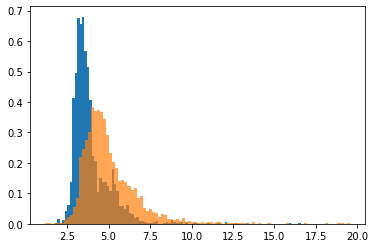

In [19]:
plt.hist(df_train[(df_train["Prediction"] == 1) & (df_train["3_feature"] < 20)]["3_feature"], bins=100, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0) & (df_train["3_feature"] < 20)]["3_feature"], bins=100, label="Norm", normed=True, alpha=0.7);

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


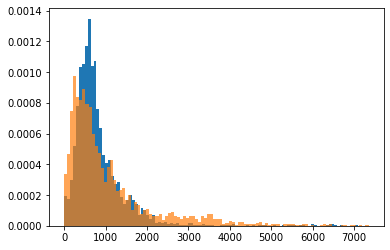

In [22]:
plt.hist(df_train[(df_train["Prediction"] == 1) & (df_train["0_feature"] < 7500)]["0_feature"], bins=100, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0) & (df_train["0_feature"] < 7500)]["0_feature"], bins=100, label="Norm", normed=True, alpha=0.7);

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


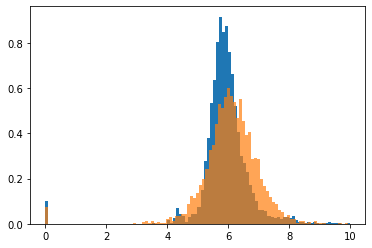

In [38]:
plt.hist(df_train[(df_train["Prediction"] == 1) & (df_train["1_feature"] < 10)]["1_feature"], bins=100, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0) & (df_train["1_feature"] < 10)]["1_feature"], bins=100, label="Norm", normed=True, alpha=0.7);

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


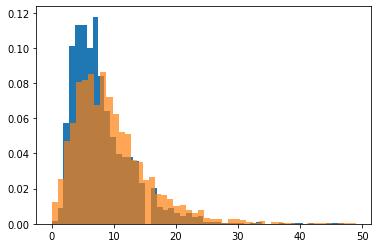

In [41]:
plt.hist(df_train[(df_train["Prediction"] == 1) & (df_train["2_feature"] < 50)]["2_feature"], bins=50, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0) & (df_train["2_feature"] < 50)]["2_feature"], bins=50, label="Norm", normed=True, alpha=0.7);

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


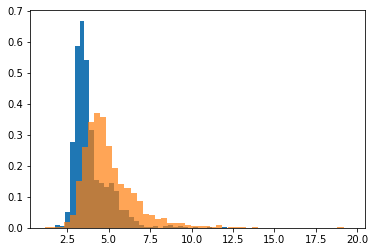

In [45]:
plt.hist(df_train[(df_train["Prediction"] == 1) & (df_train["3_feature"] < 20)]["3_feature"], bins=50, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0) & (df_train["3_feature"] < 20)]["3_feature"], bins=50, label="Norm", normed=True, alpha=0.7);

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



3.974243399871217
0.7192884919378307


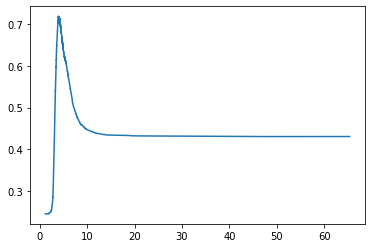

In [47]:
# f1_score auto calculation
ths_array = np.sort(np.array(df_train["3_feature"].unique()))
f1_weighted_auto = []

for th in tqdm(ths_array, total=ths_array.shape[0]):
    f1_weighted_auto.append(f1_score(df_train["Prediction"], df_train["3_feature"] < th, average="weighted"))
    
plt.plot(ths_array, f1_weighted_auto)

opt_th = ths_array[np.argmax(f1_weighted_auto)]
print(opt_th)
print(np.max(f1_weighted_auto))

In [51]:
kfold = KFold(n_splits=5, shuffle=True)

In [79]:
def optimize_threshold_f1(pred, test):
    ths_array = np.sort(np.unique(pred))
    f1_weighted_auto = []

    for th in tqdm(ths_array, total=ths_array.shape[0]):
        f1_weighted_auto.append(f1_score(test, pred > th, average="weighted"))
        
    return ths_array[np.argmax(f1_weighted_auto)], np.max(f1_weighted_auto)

In [83]:
th = 0
f1_weighted_auto = 0
for train_indices, test_indices in kfold.split(df_train):
    model = LogisticRegression()
    
    X_train = df_train.iloc[train_indices, :].loc[:, [f"{feature}_feature" for feature in range(5)]]
    y_train = df_train.iloc[train_indices, :].loc[:, ["Prediction"]]
    model.fit(X_train, y_train)
    
    X_test = df_train.iloc[test_indices, :].loc[:, [f"{feature}_feature" for feature in range(5)]]
    y_test = df_train.iloc[test_indices, :].loc[:, ["Prediction"]]
    tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_test)[:, 1], y_test)
    
    th += tmp_th
    f1_weighted_auto += tmp_f1_weighted_auto
    
print(th / kfold.get_n_splits(), f1_weighted_auto / kfold.get_n_splits())

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



0.6296632303146064 0.7228382604627434


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [85]:
model = LogisticRegression()
model.fit(df_train.loc[:, [f"{feature}_feature" for feature in range(5)]], df_train["Prediction"])
pred = model.predict_proba(df_train.loc[:, [f"{feature}_feature" for feature in range(5)]])[:, 1]
optimize_threshold_f1(pred, df_train["Prediction"])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.6276420162592775, 0.7267764924036423)

In [86]:
th = th / kfold.get_n_splits()

In [92]:
tqdm.pandas()
df_test["features"] = df_test["PageBase64"].progress_apply(take_them_all)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [95]:
df_test = df_test.drop(df_test[df_test["features"] == "Error"].index, 0)

for feature in range(5):
    df_test[f"{feature}_feature"] = df_test["features"].apply(lambda x: float(x[feature]))

df_test = df_test.drop(["features"], 1)

In [100]:
pred = model.predict_proba(df_test.loc[:, [f"{feature}_feature" for feature in range(5)]])[:, 1]
df_test["Prediction"] = pred > th
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))
df_test.head()

,Id,Prediction,Url,PageBase64,0_feature,1_feature,2_feature,3_feature,4_feature
0,-9219333997282093076,1,http://laventuhhl.ohugi.com/igor-znakomstva-ni...,PGh0bWw+DQoNCjxoZWFkPg0KPE1FVEEgY29udGVudD0idG...,771.0,5.979248,9.0,3.247172,79.0
1,-9216796593526314243,1,http://myachina9abbee.front.ru/allinone.html,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,485.0,5.536082,5.0,2.879384,72.0
2,-9216634615606576667,1,http://petropavl.kz/whouse/autor/autor4.shtml,PCEtLdCY0LTQtdGPINGB0L7Qt9C00LDQvdC40Y8g0Lgg0L...,220.0,6.559091,13.0,3.344770,24.0
3,-9215626373068452590,0,http://astro-online.ru/synastry.html,CjwhRE9DVFlQRSBIVE1MIFBVQkxJQyAiLS8vVzNDLy9EVE...,3008.0,6.550199,4.0,11.130094,48.0
4,-9215403080479774736,1,http://oxoyhetc.hopto.org/13/62.html,DQoNCg0KPEhUTUw+DQo8SEVBRD4NCjx0aXRsZT7QotC10L...,665.0,6.225564,7.0,3.609824,95.0


In [101]:
df_test.loc[:, ["Id", "Prediction"]].to_csv("antispam_submission_06_05.csv", index=False)